In [1]:
import xarray as xr
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import numpy as np
import calendar
import pandas as pd

import matplotlib
from matplotlib import transforms
import seaborn as sns

from sklearn.linear_model import LinearRegression 
from scipy.stats import distributions

In [2]:
windspeed245 = xr.open_dataset('wind_processed/sfcWind_ssp245.nc')

C:\Users\kaits\anaconda3\Lib\site-packages\xarray\backends\plugins.py:71: RuntimeWarning: Engine 'cfgrib' loading failed:
Cannot find the ecCodes library
  warnings.warn(f"Engine {name!r} loading failed:\n{ex}", RuntimeWarning)


In [11]:
monthly_average_data = windspeed245['sfcWind'].groupby("time.month").mean(dim="time")
proj = ccrs.Mollweide() 
months = list(calendar.month_name)[1:]

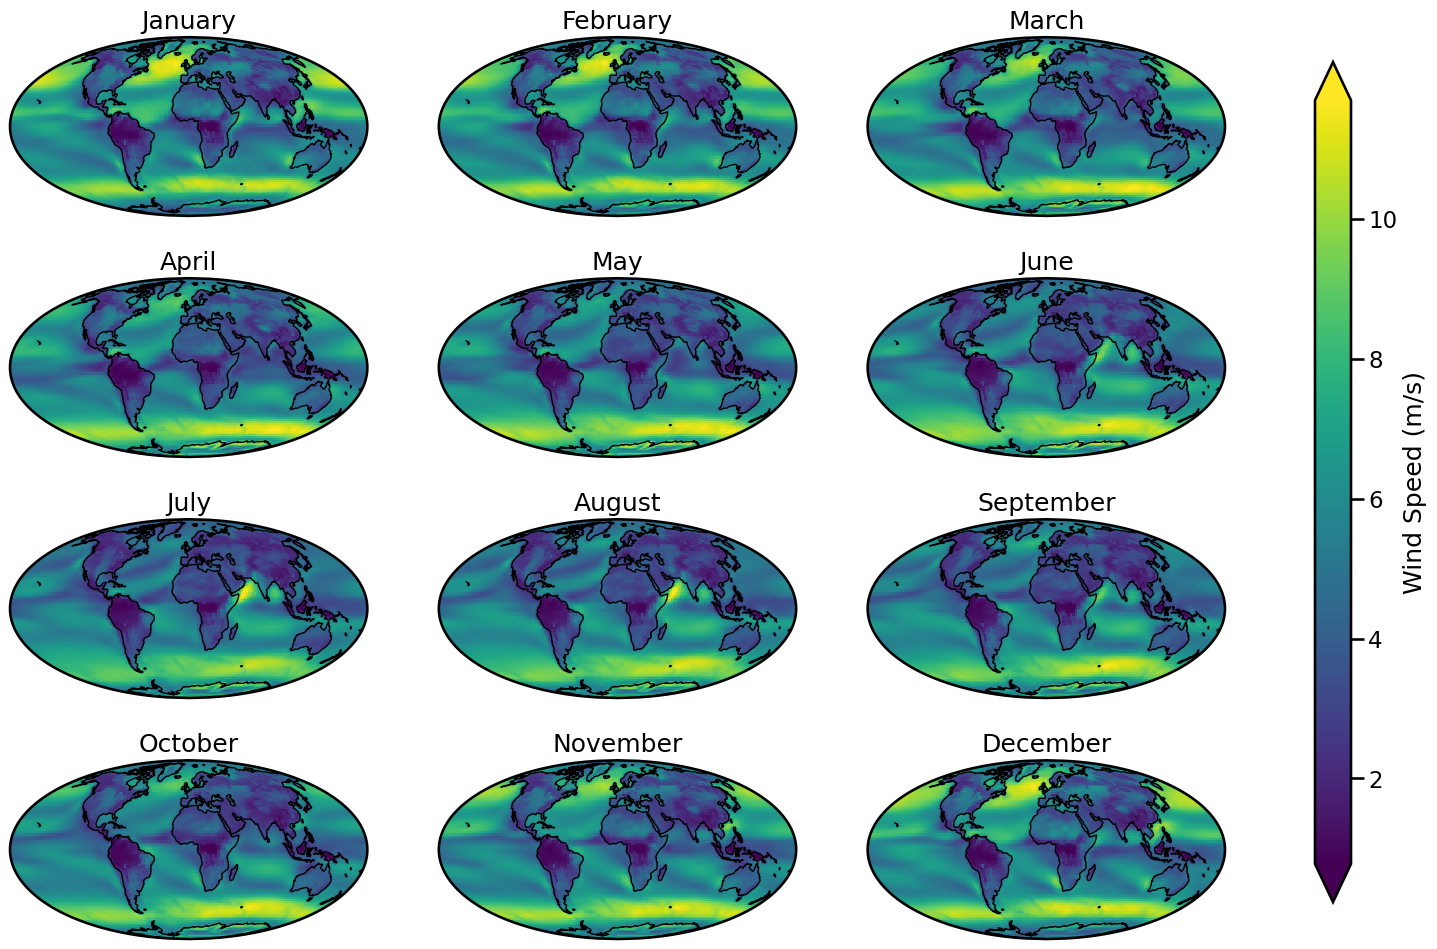

In [42]:
with sns.plotting_context("talk"):
    fig = plt.figure(figsize=(18, 12))
    
    for i in range(12):
        plt.subplot(4, 3, i+1, projection=proj)
        m = monthly_average_data[i].plot(transform=ccrs.PlateCarree(), add_colorbar=False)
        plt.gca().coastlines()
        plt.gca().set_title(months[i])

    fig.subplots_adjust(right=0.8)
    cbar_ax = fig.add_axes([0.85, 0.15, 0.02, 0.7])
    cbar = fig.colorbar(m, cax=cbar_ax, extend='both')
    cbar.set_label('Wind Speed (m/s)')

In [ ]:
# get maximum difference of min and max in a year

In [51]:
yearly_max = windspeed245['sfcWind'].groupby("time.year").max(dim="time")
yearly_min = windspeed245['sfcWind'].groupby("time.year").min(dim="time")
yearly_diff = yearly_max - yearly_min
yearly_diff_max = yearly_diff.max(dim="year")
yearly_diff_avg = yearly_diff.mean(dim="year")

proj = ccrs.PlateCarree()

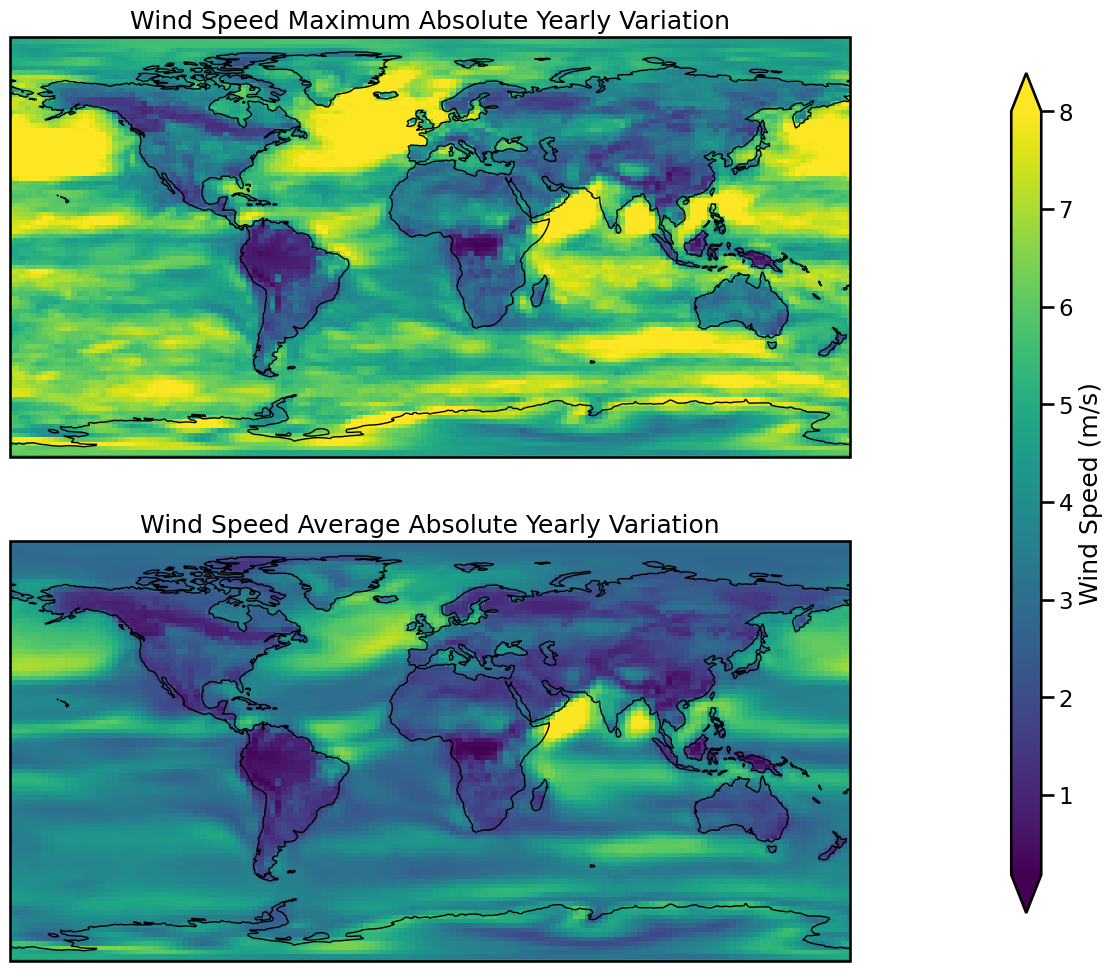

In [111]:
with sns.plotting_context("talk"):
    fig = plt.figure(figsize=(15, 12))
    
    for i in range(2):
        plt.subplot(2, 1, i+1, projection=proj)
        if i == 0:
            data = yearly_diff_max
            grouping = 'Maximum'
        else:
            data = yearly_diff_avg
            grouping = 'Average'
        m = data.plot(transform=ccrs.PlateCarree(), add_colorbar=False, vmax=8)
        plt.gca().coastlines()
        plt.gca().set_title(f'Wind Speed {grouping} Absolute Yearly Variation')

    fig.subplots_adjust(right=0.8)
    cbar_ax = fig.add_axes([0.85, 0.15, 0.02, 0.7])
    cbar = fig.colorbar(m, cax=cbar_ax, extend='both')
    cbar.set_label('Wind Speed (m/s)')

In [ ]:
# percentage difference: (max-min)/avg * 100%

In [107]:
yearly_avg = (yearly_min + yearly_max)/2
yearly_percent = yearly_diff / yearly_avg * 100
yearly_percent_max = yearly_percent.max(dim="year")
yearly_percent_avg = yearly_percent.mean(dim="year")

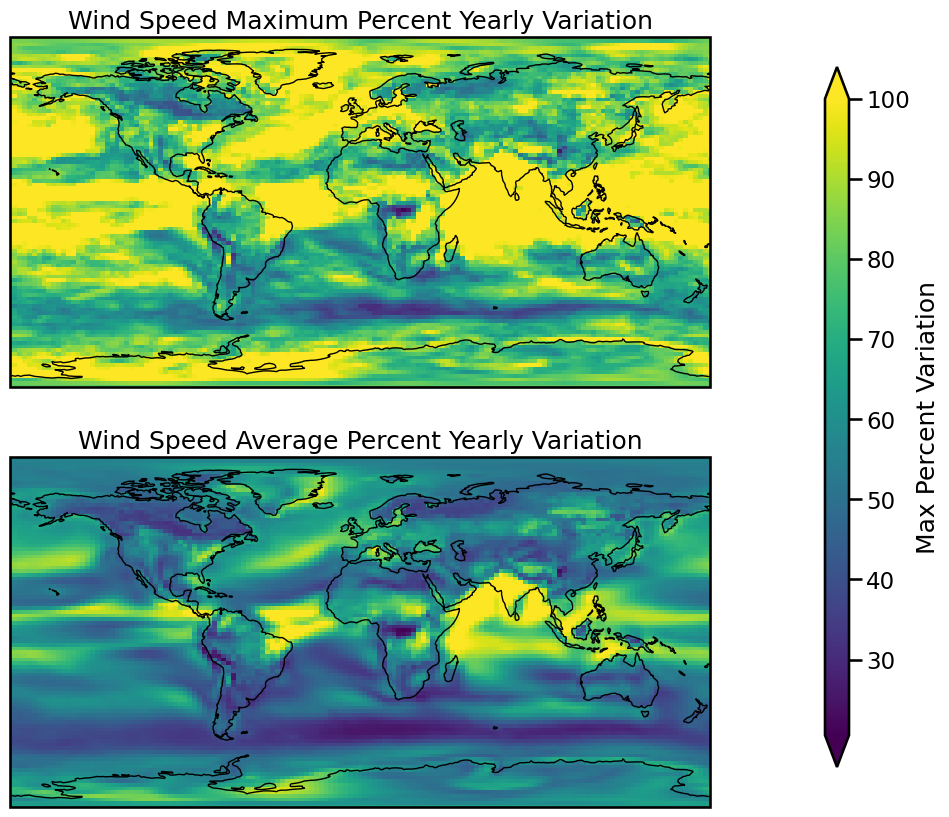

In [129]:
with sns.plotting_context("talk"):
    fig = plt.figure(figsize=(12, 10))
    
    for i in range(2):
        plt.subplot(2, 1, i+1, projection=proj)
        if i == 0:
            data = yearly_percent_max
            grouping = 'Maximum'
        else:
            data = yearly_percent_avg
            grouping = 'Average'
        m = data.plot(transform=ccrs.PlateCarree(), add_colorbar=False, vmax=100)
        plt.gca().coastlines()
        plt.gca().set_title(f'Wind Speed {grouping} Percent Yearly Variation')

    fig.subplots_adjust(right=0.8)
    cbar_ax = fig.add_axes([0.85, 0.15, 0.02, 0.7])
    cbar = fig.colorbar(m, cax=cbar_ax, extend='both')
    cbar.set_label('Max Percent Variation')

In [ ]:
# wind speed change between first 10 and last 10 years

In [114]:
yearly_avg = windspeed245['sfcWind'].groupby('time.year').mean(dim='time')
first10 = yearly_avg.sel(year=slice(2015,2024)).mean(dim='year')
last10 = yearly_avg.sel(year=slice(2091,None)).mean(dim='year')
diff10s = last10-first10

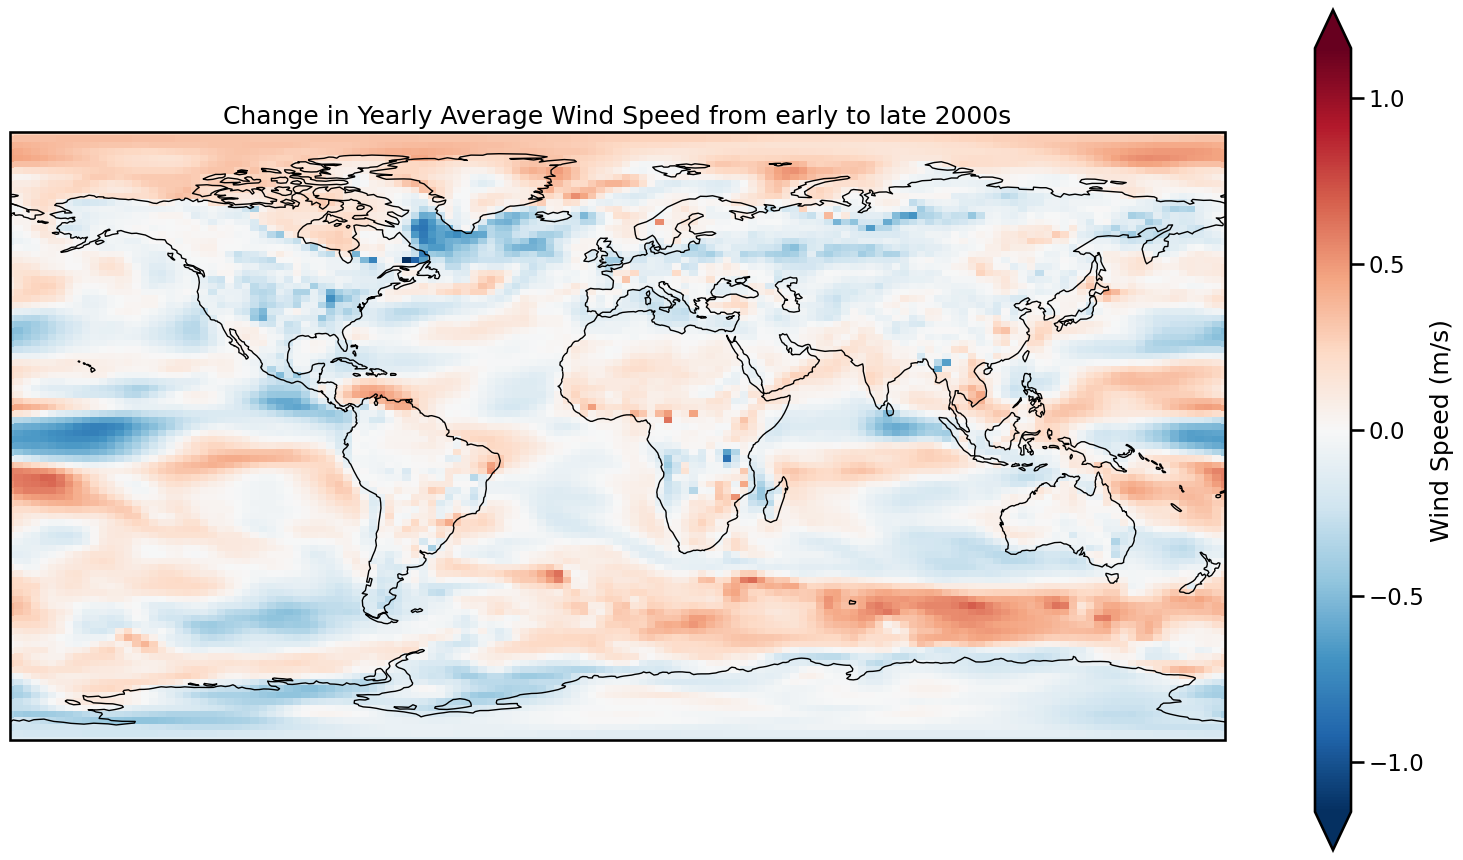

In [126]:
with sns.plotting_context("talk"):
    fig = plt.figure(figsize=(18, 12))
    
    for i in range(1):
        plt.subplot(1, 1, i+1, projection=proj)
        m = diff10s.plot(transform=ccrs.PlateCarree(), add_colorbar=False)
        plt.gca().coastlines()
        plt.gca().set_title('Change in Yearly Average Wind Speed from early to late 2000s')

    fig.subplots_adjust(right=0.8)
    cbar_ax = fig.add_axes([0.85, 0.15, 0.02, 0.7])
    cbar = fig.colorbar(m, cax=cbar_ax, extend='both')
    cbar.set_label('Wind Speed (m/s)')

In [204]:
# functions to compute various NRMSEs
def get_nrmse_spatial(truth, pred):
    weights = np.cos(np.deg2rad(truth.lat))
    truth = truth.sel(year=slice(2080,None))
    pred = pred[-21:]
    truth_total = np.abs(truth.weighted(weights).mean(['lat', 'lon']).data.mean())
    rmse_spatial = np.sqrt(((truth - pred).mean('year')**2).weighted(weights).mean(['lat','lon'])).data
    return rmse_spatial / truth_total 

def get_nrmse_global(truth, pred):
    weights = np.cos(np.deg2rad(truth.lat))
    truth = truth.sel(year=slice(2080,None))
    pred = pred[-21:]
    truth_total = np.abs(truth.weighted(weights).mean(['lat', 'lon']).data.mean())
    rmse_global = np.sqrt((((truth - pred).weighted(weights).mean(['lat', 'lon']))**2).data.mean())
    return rmse_global / truth_total 

def get_nrmse(truth, pred):
    return get_nrmse_spatial(truth, pred) + 5 * get_nrmse_global(truth, pred)

In [132]:
# computes t-test for differences
def ttest_rel_from_stats(diff_mean, diff_std, diff_num):
    z = diff_mean / np.sqrt(diff_std ** 2 / diff_num)
    p = distributions.t.sf(np.abs(z), diff_num - 1) * 2
    return z, p

In [135]:
train_scenarios = ['hist-aer', 'hist-GHG', 'ssp126', 'ssp370', 'ssp370lowNTCF', 'ssp585']

In [192]:
# average data over ensemble members
Xtrain = xr.concat(
    [xr.open_dataset(f'wind_processed/sfcWind_{s}.nc').groupby("time.year").mean(dim="time") for s in train_scenarios]
    , dim='year')

In [194]:
# mean temp averaged globally and over training simulations
weights = np.cos(np.deg2rad(Xtrain.lat))
global_mean_wind = Xtrain['sfcWind'].weighted(weights).mean(['lat', 'lon']).to_numpy().reshape(-1,1)

In [195]:
# load test data
Ytest = xr.open_dataset(f'wind_processed/sfcWind_ssp245.nc').groupby("time.year").mean(dim="time")

In [196]:
# get mean temperature averaged globally
test_input = (Ytest['sfcWind']
              .weighted(weights)
              .mean(['lat', 'lon'])
              .to_pandas() # convert to pandas to use rolling average
              .rolling(10, min_periods=1)
              .mean()
              .to_numpy() # convert back to numpy to reshape
              .reshape(-1,1))

In [197]:
# create model
model = LinearRegression(fit_intercept=False)
model.fit(global_mean_wind, Xtrain['sfcWind'].stack(dim=['lat','lon']))

LinearRegression(fit_intercept=False)

In [198]:
output = model.predict(test_input).reshape(86,96,144)

In [207]:
nrmses = [
    [
        get_nrmse_spatial(Ytest[out], output), 
        get_nrmse_global(Ytest[out], output),
        get_nrmse(Ytest[out], output)
    ] 
    for out in ['sfcWind']]

nrmse_table = pd.DataFrame(data=nrmses, index=['sfcWind'], columns=['spatial', 'global', 'total']).round(3)
nrmse_table

,spatial,global,total
sfcWind,0.027,0.004,0.047


In [219]:
# turn output into dataarray to plot
xr_output=xr.Dataset(
    coords={'year': Ytest.year.values, 'lat': Ytest.lat.values, 'lon': Ytest.lon.values})

xr_output['sfcWind'] = (['year', 'lat', 'lon'], output)

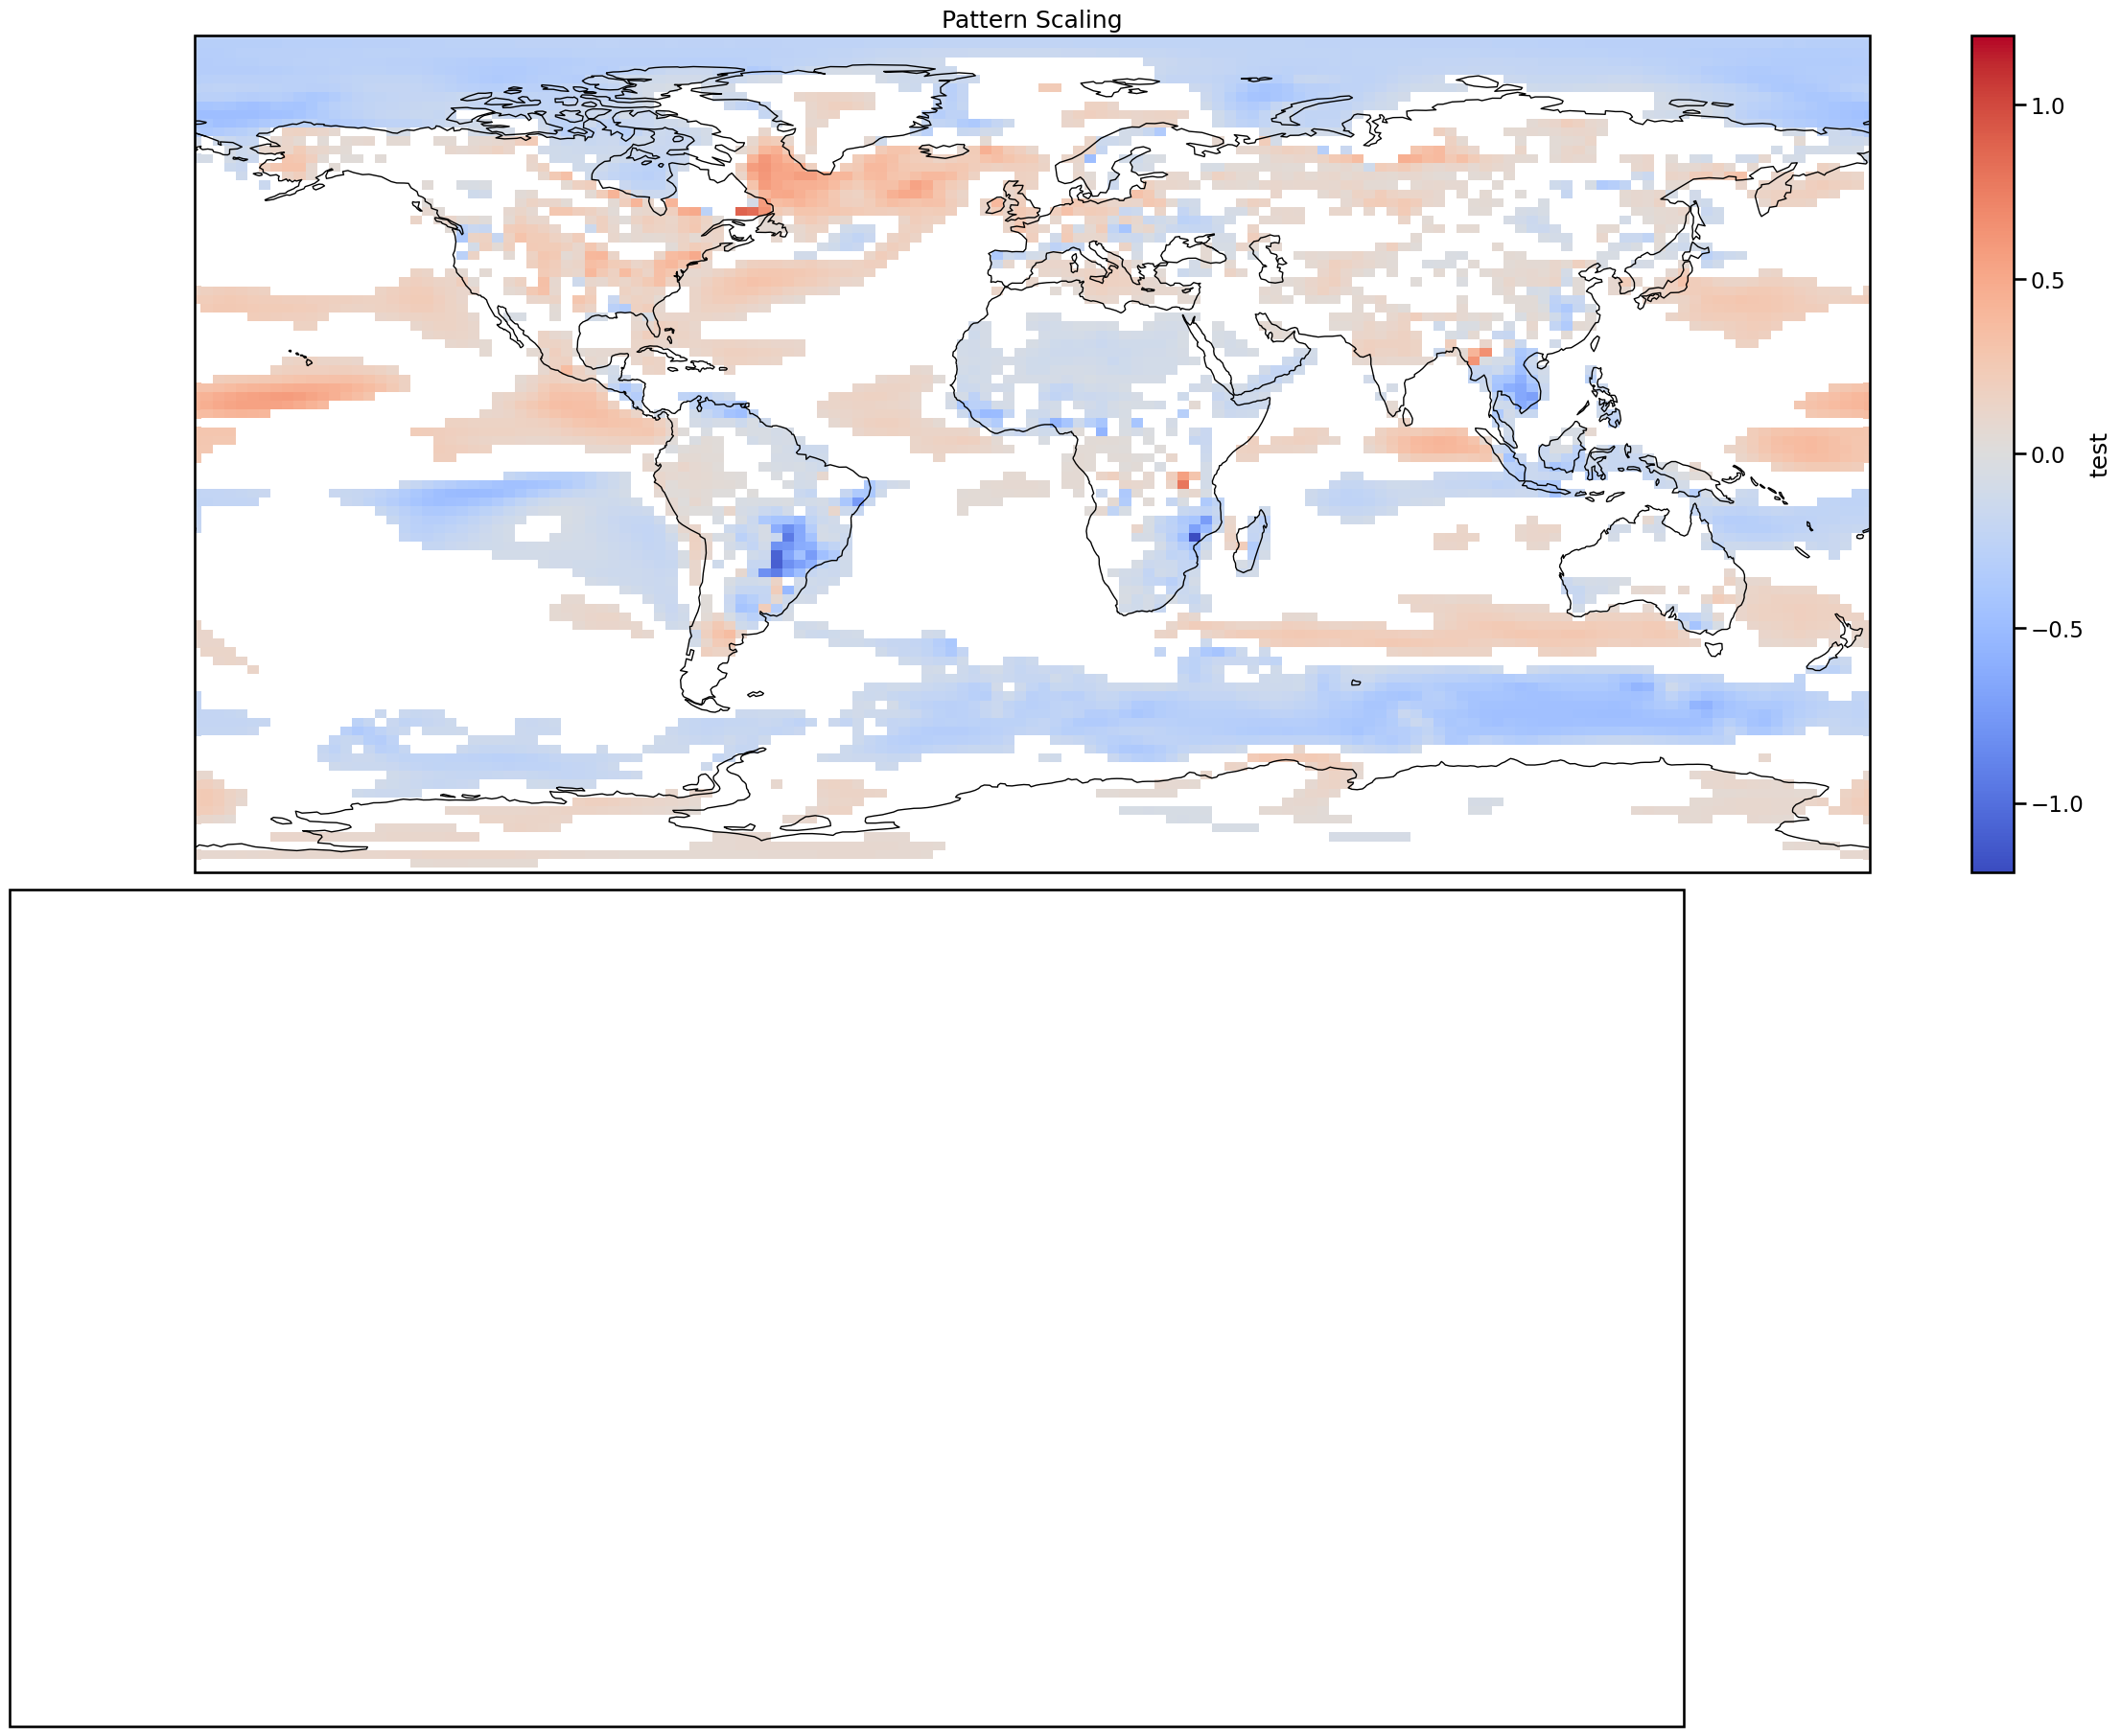

In [226]:
p_level = 0.05

with sns.plotting_context("talk"):
    fig, axes = plt.subplots(2, 1, subplot_kw=dict(projection=proj), figsize=(24, 18), constrained_layout=True)
    for i in range(1):
        out = 'sfcWind'
        diff = xr_output[out][-21:] - ytest[out][-21:]
        ax = axes[i]
        
        ax.set_title('Pattern Scaling')
        mean_diff = diff.mean('year')
        _, p = ttest_rel_from_stats(mean_diff, diff.std('year'), diff.count('year'))
        
        
        (mean_diff.where(p < p_level)
                  .plot(
                     cmap="coolwarm", 
                     ax=ax, 
                     add_labels=False, 
                     transform=ccrs.PlateCarree(), 
                     cbar_kwargs={"label":"test", "orientation":'vertical'}))
        ax.coastlines()